# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os
PATH = "/content/drive/My Drive/Colab Notebooks/"
os.chdir(PATH)


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
# IMPORT LIBRARIES AND PACKAGES

import csv
import math
import cv2

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
data = np.load('./images_small.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [19]:
for key in data:
    print (key)
    print (data[10][1])
    break

[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.306306

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
# SETTINGS

ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 1
BATCH_SIZE = 4
PATIENCE = 10

THREADS = 1

PATH = "/content/drive/My Drive/Colab Notebooks/"

TRAIN_CSV = PATH+"train.csv"
VALIDATION_CSV = PATH+"validation.csv"

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [22]:
X_train.shape

(200, 224, 224, 3)

In [23]:
masks.shape

(200, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

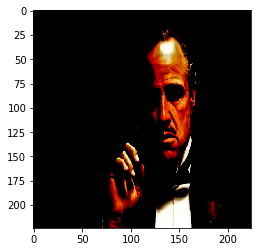

In [24]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

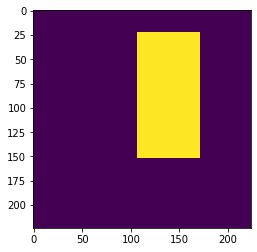

In [25]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = #### Add your code here ####
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #### Add your code here ####

    return #### Add your code here ####
    

In [0]:
class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.mask = np.zeros((sum(1 for line in file), HEIGHT_CELLS, WIDTH_CELLS))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")

            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, _ = row

                path_mask = path.replace('.jpg','.png')

                mask_img = cv2.imread(path_mask)
                mask_img = (mask_img!=2)*1.0
                mask_img = cv2.resize(mask_img, (28, 28))
                mask_img = 1.0*(mask_img[:,:,0]>0.2)
                self.mask[index,:,:] = np.squeeze(mask_img)
                
                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.mask) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_masks = self.mask[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, batch_masks

### Call the create_model function

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [30]:
model = create_model(False)
model.summary()

train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = DataGenerator(VALIDATION_CSV)

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112

FileNotFoundError: ignored

### Define checkpoint and earlystopping

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    validation_data=validation_datagen,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

### Get the predicted mask for a sample image   (3 marks)

In [0]:
n = 10
sample_image = X_train[n]



In [33]:
import cv2
import numpy as np

from keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


### Impose the mask on the image (3 marks)

In [0]:
WEIGHTS_FILE = "model-0.92.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)